# Numerical exercise 01


In [19]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math


## Exercise 01.1

#### Assignment
- Test the Pseudo-Random Number generator downloaded from the NSL Ariel web site by estimating:

1. $\langle r \rangle = \int_0^1 r dr = 1/2$. Make a picture of the estimation of $\langle r \rangle$ and its uncertainty (which corresponds to Standard Deviation of the mean for the estimation of $\langle r \rangle$) with a large number of *throws* $M$ (e.g. $M\ge 10^4$) as a function of the number of blocks, $N$ (see below: Computing statistical uncertainties).
2. $\sigma^2 = \int_0^1 (r-1/2)^2 dr = 1/12$. Make a picture of the estimation of $\sigma^2$ and its uncertainty (which corresponds to Standard Deviation of the mean for the estimation of $\langle (r-1/2)^2 \rangle$) with a large number of *throws* $M$ (e.g. $M\ge 10^4$) as a function of the number of blocks, $N$ (see below: Computing statistical uncertainties).
3. Divide $[0,1]$ into $M$ identical sub-intervals and implement the $\chi^2$ test. Obviously, the number of expected events observed in each sub-interval after $n$ *throws*, according to a uniform distribution, is $np = n\times 1/M= n/M$. Fix $M=10^2$ and use for $n$ the first $10^4$ pseudo-random numbers, then the successive $10^4$ pseudo-random numbers, and so on ... 100 times. Plot $\chi^2_j$ for $j=1, ..., 100$. In this case the chi-square statistic is:
$$\chi^2 = \sum_{i=1}^M \frac{\left( n_i - n/M \right)^2}{n/M}$$
We should expect on average that $(n_i - n/M)^2 \simeq n/M$ and thus $\chi^2 \simeq 100$, i.e. the number of sub-intervals.
A larger value of $\chi^2$ indicates that the hypothesis ($n_i$ are drawn from a uniform distribution) is rather unlikely ... but before judging, you could compare the histogram of the values obtained for $\chi^2_j$ with the true probability distribution (see: <a href="https://en.wikipedia.org/wiki/Chi-squared_distribution">this Wikipedia link</a>).

### Exercise 01.1.1


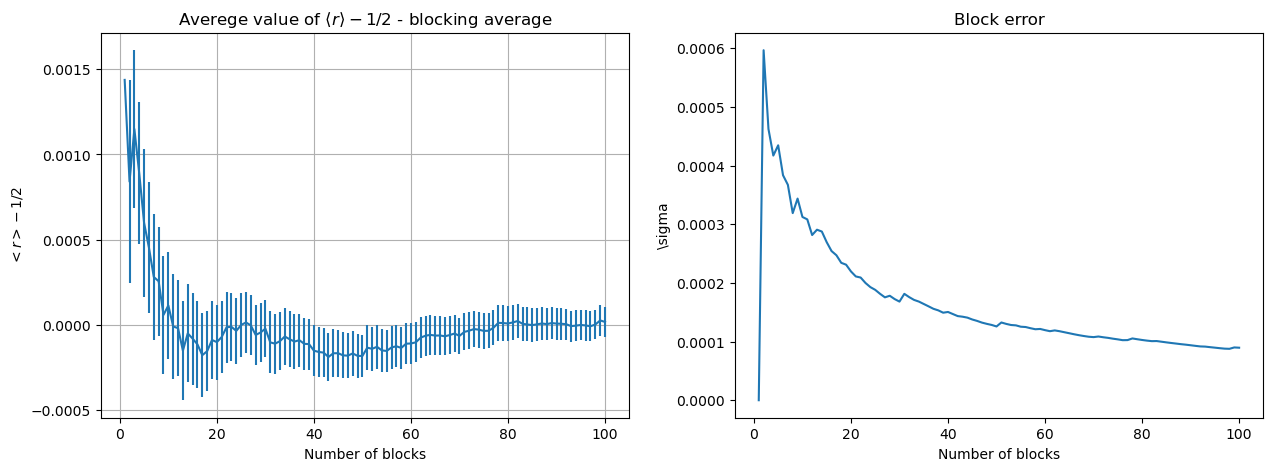

In [20]:
n_throws, cum_avg, block_error = np.loadtxt("../data/ex_01.1a.dat", unpack=True, usecols=(0,1,2))

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.errorbar(n_throws, cum_avg-0.5, yerr=block_error)
plt.title(r"Averege value of $\langle r \rangle - 1/2$ - blocking average")
plt.xlabel('Number of blocks')
plt.ylabel(r"$<r>-1/2$")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(n_throws, block_error)
plt.title("Block error")
plt.xlabel('Number of blocks')
plt.ylabel(r"\sigma")


plt.show()

### Exercise 01.1.2


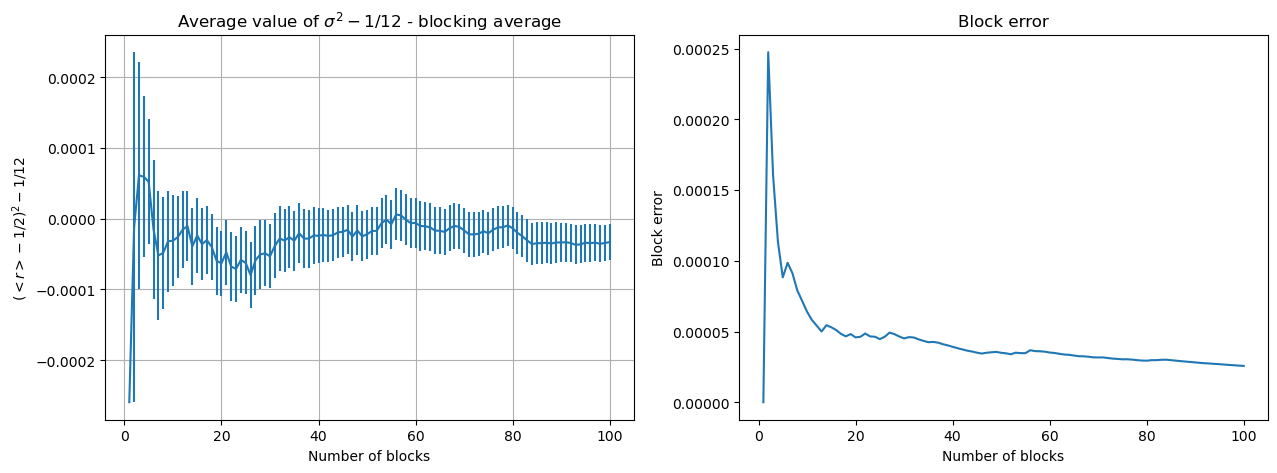

In [21]:
vn_throws, vcum_avg, vblock_error = np.loadtxt("../data/ex_01.1b.dat", unpack=True, usecols=(0,1,2))

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.errorbar(vn_throws, vcum_avg-1/12, yerr=vblock_error)
plt.title(r"Average value of $\sigma^2 - 1/12$ - blocking average")
plt.xlabel('Number of blocks')
plt.ylabel(r"$(<r>-1/2)^2 - 1/12$")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(vn_throws, vblock_error)
plt.title("Block error")

plt.xlabel('Number of blocks')
plt.ylabel('Block error')

plt.show()



### Exercise 01.1.3

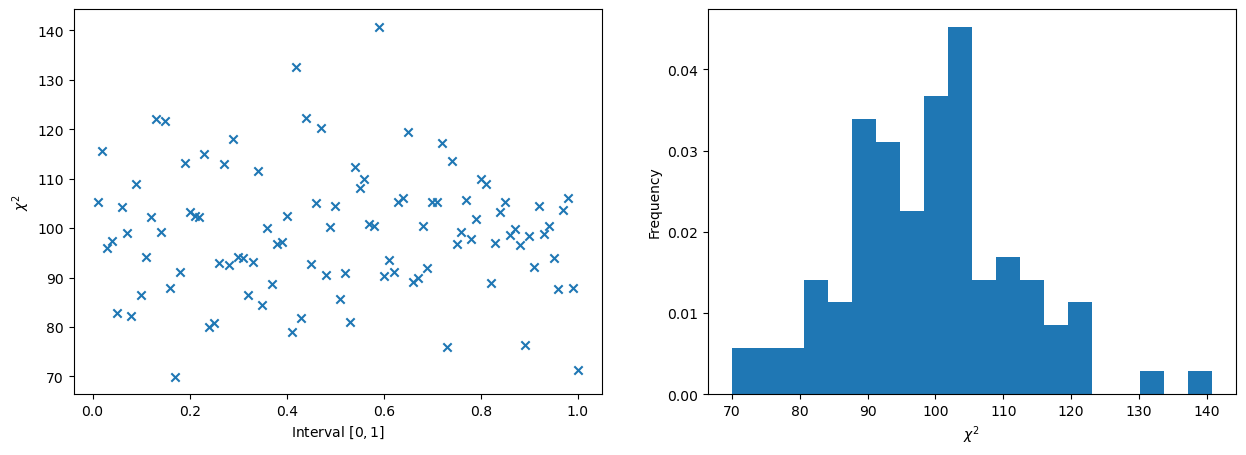

Mean = 99.12, std = 12.55


In [22]:
point, chi2 = np.loadtxt("../data/ex_01.1c.dat", unpack=True, usecols=(0,1))

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.scatter(point*(1/100), chi2, marker="x")
plt.xlabel(r"Interval $[0,1]$")
plt.ylabel(r"$\chi^2$")

plt.subplot(1,2,2)
plt.hist(chi2, 20, density=True)
plt.xlabel(r"$\chi^2$")
plt.ylabel("Frequency")
plt.show()

print("Mean = {0:.2f}, std = {1:.2f}".format(chi2.mean(), chi2.std()))


## Exercise 01.2

#### Assignment
- Extend Pseudo-Random Number generator downloaded from the NSL Ariel web site and check the Central Limit Theorem:
1. Add two probability distributions by using the **method of the inversion of the cumulative distribution** to sample from a **generic** exponential distribution, $p(x) = \lambda \exp(-\lambda x)$, $x\in [0;+\infty]$ (see <a href="https://en.wikipedia.org/wiki/Exponential_distribution">this Wikipedia link</a>), and a **generic** Cauchy-Lorentz distribution $p(x)=\frac{1}{\pi}\frac{\Gamma}{(x-\mu)^2+\Gamma^2}$, $x\in [-\infty;+\infty]$ (see <a href="https://en.wikipedia.org/wiki/Cauchy_distribution">this Wikipedia link</a>).
2. Make 3 pictures with the histograms obtained filling them with $10^4$ realizations of $S_N = \frac{1}{N}\sum_{i=1}^N x_i$ (for $N=1, 2, 10, 100$), being $x_i$ a random variable sampled throwing a *standard* dice (fig.1), an *exponential* dice (fig.2, use $\lambda=1$) and a *Lorentzian* dice (fig.3, use $\mu=0$ and $\Gamma=1$).

Note tha you can try to fit the case $N=100$ with a Gaussian for standard and exponential dices, whereas you should use a Cauchy-Lorentz distribution for the last case.

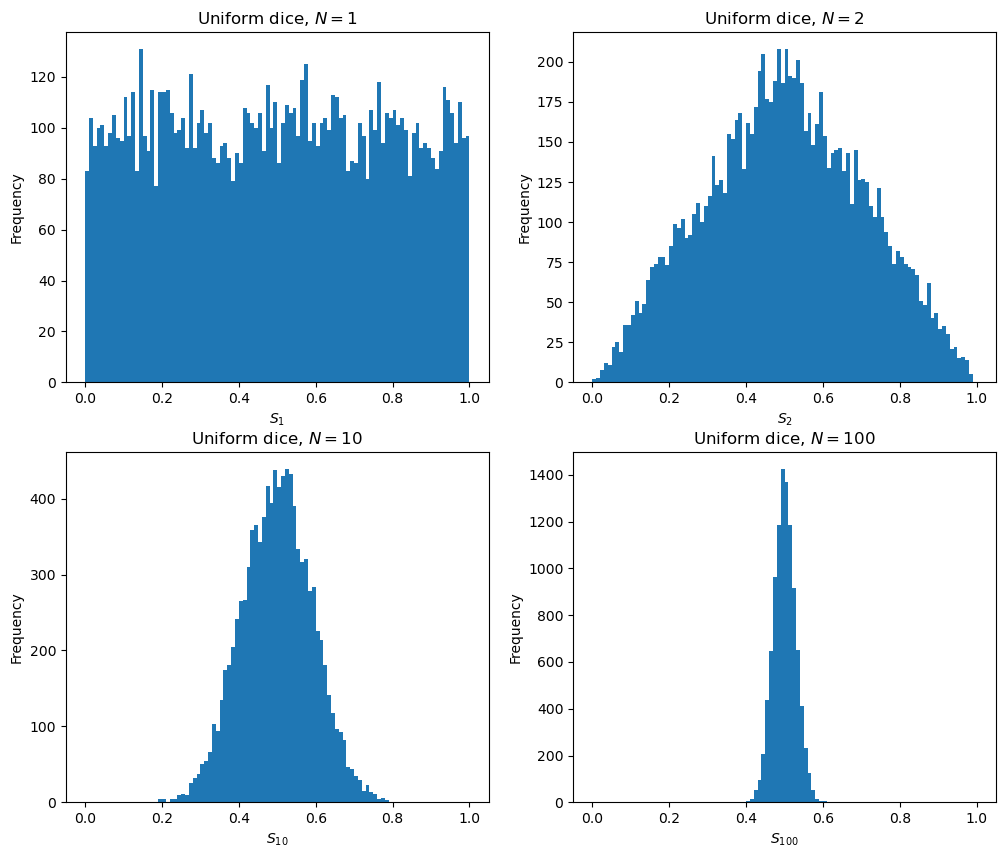

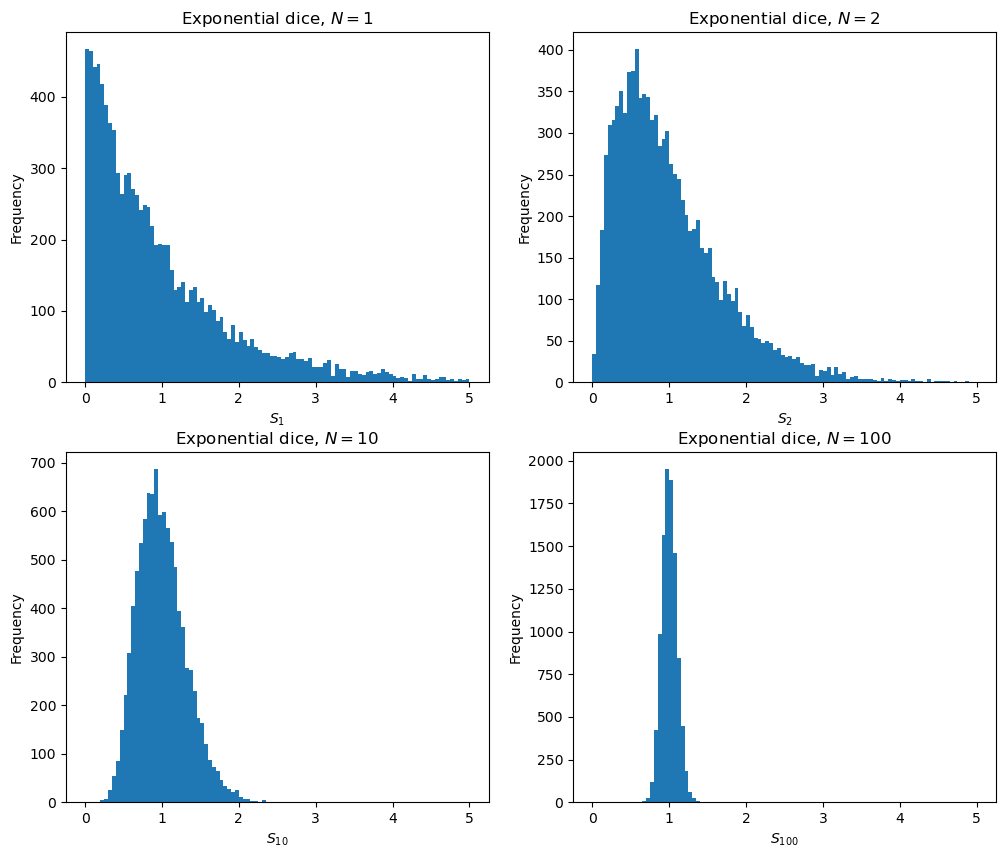

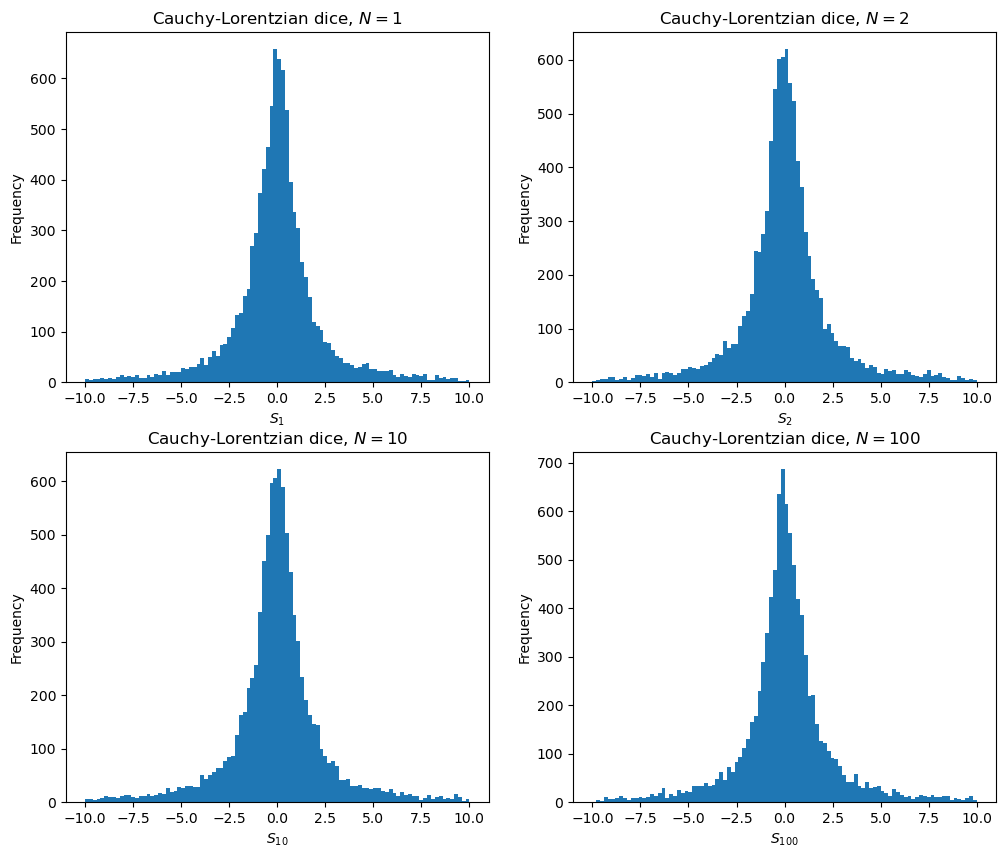

In [23]:
sumsize = [1, 2, 10, 100]    
name = [
    "Uniform dice",
    "Exponential dice",
    "Cauchy-Lorentzian dice"
]

unif_s1, expo_s1, cauchy_s1         = np.loadtxt("../data/ex_01.2s_1.dat", unpack=True, usecols=(0,1,2))
unif_s2, expo_s2, cauchy_s2         = np.loadtxt("../data/ex_01.2s_2.dat", unpack=True, usecols=(0,1,2))
unif_s10, expo_s10, cauchy_s10      = np.loadtxt("../data/ex_01.2s_10.dat", unpack=True, usecols=(0,1,2))
unif_s100, expo_s100, cauchy_s100   = np.loadtxt("../data/ex_01.2s_100.dat", unpack=True, usecols=(0,1,2))

unif = [unif_s1, unif_s2, unif_s10, unif_s100]

data = [
    [unif_s1, unif_s2, unif_s10, unif_s100],
    [expo_s1, expo_s2, expo_s10, expo_s100],
    [cauchy_s1, cauchy_s2, cauchy_s10, cauchy_s100]
]

limits = [
    (0,1),
    (0,5),
    (-10,10)
]

n_bins = 100

for dist in range(3):
    plt.figure(figsize = (12,10))
    for sum in range(4):
        plt.subplot(2,2,sum+1)
        m = plt.hist(data[dist][sum], n_bins, range=limits[dist])
        plt.title(r"{name}, $N={size}$".format(name=name[dist], size=sumsize[sum]))
        plt.xlabel(r"$S_{%d}$" % sumsize[sum])
        plt.ylabel("Frequency")
    plt.show()




## Exercise 01.3

#### Assignment
- **Simulate** the Buffon’s experiment (see LSN_Lecture_00, supplementary material):  A needle of length $L$ is thrown at random onto a horizontal plane ruled with straight lines a distance $d$ (must be $d > L$, but do not use $d\gg L$ otherwise $P\ll 1$) apart. The probability $P$ that the needle will intersect one of these lines is: $P = 2L/\pi d$. This could be used to evaluate $\pi$ from throws of the needle: if the needle is thrown down $N_{thr}$ times and is observed to land on a line $N_{hit}$ of those times, we can make an estimate of $\pi$ from
$$\pi = \frac{2L}{Pd} = \lim_{N_{thr} \to \infty}\frac{2LN_{thr}}{N_{hit}d}$$
Make a picture of the estimation of $\pi$ and its uncertainty (Standard Deviation of the mean) with a large number of *throws* $M$ as a function of the number of blocks, $N$ (see below: Computing statistical uncertainties). If possible, do not use $\pi$ to evaluate $\pi$.

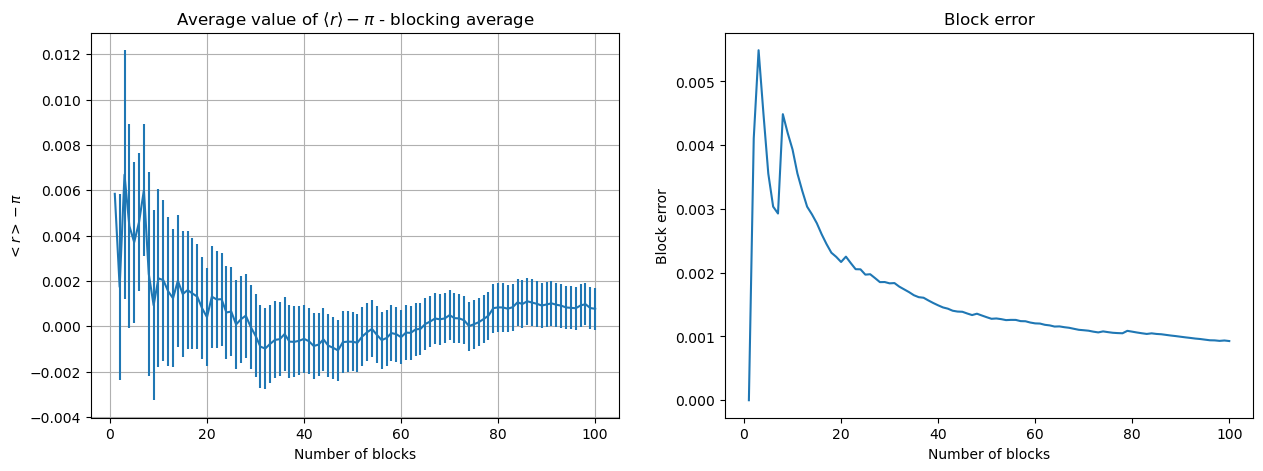

In [25]:

n_throws, cum_avg, block_error = np.loadtxt("../data/ex_01.3.dat", unpack=True, usecols=(0,1,2))

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.errorbar(n_throws, cum_avg-np.pi, yerr=block_error)
plt.title(r"Average value of $\langle r \rangle - \pi$ - blocking average")
plt.xlabel('Number of blocks')
plt.ylabel(r"$<r> - \pi$")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(n_throws, block_error)
plt.title("Block error")
plt.xlabel('Number of blocks')
plt.ylabel('Block error')

plt.show()

